In [1]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [2]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
# from src.ParticleFilter import PFHeston
# from src.RealizedGARCH import RealizedGARCH
from src.Heston import *
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings

/Users/hyunminhong/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [39]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 11.0,
    'theta': 0.04,
    'xi': 0.9
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] / params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 1, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=1
)
R_daily = daily_returns.copy()

1.09


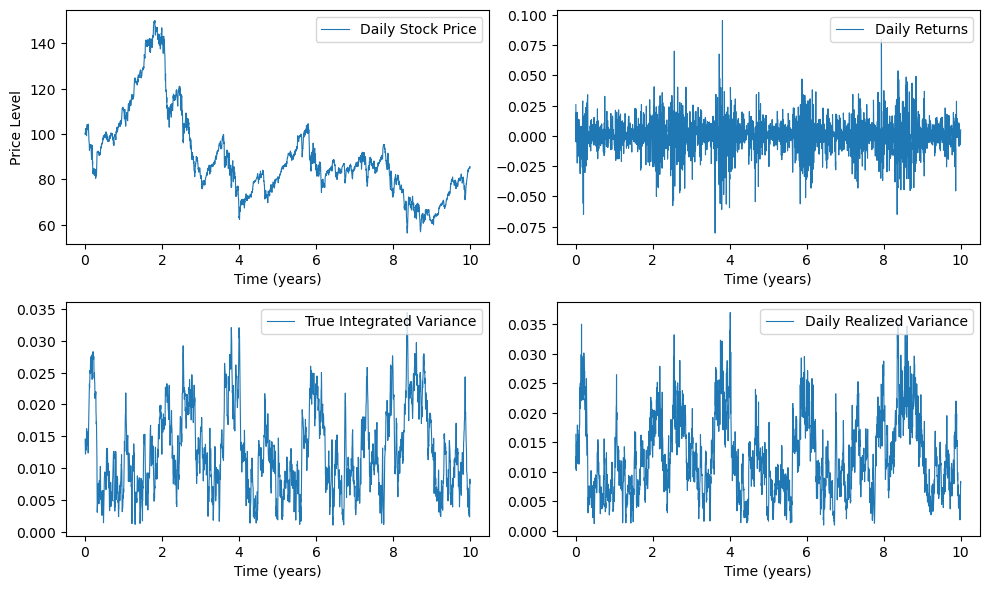

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, np.sqrt(daily_true_V), label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, np.sqrt(daily_RV), label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [41]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### RV

In [ ]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001]) # 'kappa', 'theta', 'xi', 'sigma'

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
test_result_rv = hkf_rv_test.filter(params=params_opt_rv, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.22531D+03    |proj g|=  6.51469D+06

At iterate    1    f= -7.32817D+03    |proj g|=  1.12013D-01

At iterate    2    f= -8.52435D+03    |proj g|=  3.27694D-02
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    3    f= -8.63386D+03    |proj g|=  3.26511D-02

At iterate    4    f= -1.00859D+04    |proj g|=  3.23707D+05



 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f= -1.02812D+04    |proj g|=  8.83603D+01

At iterate    6    f= -1.04301D+04    |proj g|=  7.23228D+02

At iterate    7    f= -1.04492D+04    |proj g|=  1.27121D+04

At iterate    8    f= -1.04520D+04    |proj g|=  1.20940D+04

At iterate    9    f= -1.04538D+04    |proj g|=  2.77677D+03

At iterate   10    f= -1.04541D+04    |proj g|=  1.42582D+03

At iterate   11    f= -1.04543D+04    |proj g|=  1.75444D+03

At iterate   12    f= -1.04556D+04    |proj g|=  3.04821D+03

At iterate   13    f= -1.04562D+04    |proj g|=  2.44358D+03

At iterate   14    f= -1.04577D+04    |proj g|=  1.65689D+03

At iterate   15    f= -1.04605D+04    |proj g|=  4.69984D+03

At iterate   16    f= -1.04609D+04    |proj g|=  5.85125D+02

At iterate   17    f= -1.04609D+04    |proj g|=  1.86251D+02

At iterate   18    f= -1.04609D+04    |proj g|=  2.21566D+01

At iterate   19    f= -1.04609D+04    |proj g|=  1.06120D+02

At iterate   20    f= -1.04609D+04    |proj g|=  1.54692D+02

At iter

### HAR-RV

In [43]:
def har_rv_forecast(train_RV, test_RV):
    train_RV = pd.Series(train_RV)
    test_RV = pd.Series(test_RV)
    
    lag1_tr = train_RV.shift(1)
    lag5_tr = train_RV.rolling(5).mean().shift(1)
    lag21_tr = train_RV.rolling(21).mean().shift(1)
    
    df_tr = pd.DataFrame({
        'y': train_RV,
        'x1': lag1_tr,
        'x5': lag5_tr,
        'x21': lag21_tr
    }).dropna()
    
    X_tr = sm.add_constant(df_tr[['x1', 'x5', 'x21']])
    model = sm.OLS(df_tr['y'], X_tr)
    results = model.fit()
    
    beta_const = results.params['const']
    beta_x1 = results.params['x1']
    beta_x5 = results.params['x5']
    beta_x21 = results.params['x21']
    
    full_RV = pd.concat([train_RV, test_RV])
    
    # Compute lags on the full series
    lag1_full = full_RV.shift(1)
    lag5_full = full_RV.rolling(5).mean().shift(1)
    lag21_full = full_RV.rolling(21).mean().shift(1)
    
    # Extract ONLY the test period features
    test_start_idx = len(train_RV)
    test_end_idx = len(full_RV)
    
    # Test set features
    x1_test = lag1_full.iloc[test_start_idx:test_end_idx]
    x5_test = lag5_full.iloc[test_start_idx:test_end_idx]
    x21_test = lag21_full.iloc[test_start_idx:test_end_idx]
    
    forecasts = beta_const + beta_x1 * x1_test + beta_x5 * x5_test + beta_x21 * x21_test
    
    # forecasts = forecasts.dropna()
    
    if len(forecasts) == 0:
        raise ValueError("All forecasts are NaN. Ensure training data has >21 periods and no missing values.")
    
    # Align with test_RV index
    forecast_index = test_RV.index[:len(forecasts)]
    forecasts = pd.Series(forecasts.values, index=forecast_index, name='HAR_RV_pred')
    
    # Get fitted values (in-sample fit) from training phase
    fitted_values = results.fittedvalues
    n_missing = len(train_RV) - len(fitted_values)
    if n_missing > 0:
        padding = pd.Series([0.0] * n_missing, index=train_RV.index[:n_missing])
        fitted_values = pd.concat([padding, fitted_values])
        fitted_values.name = 'HAR_RV_fitted'
    
    # Return parameters as a dictionary for clarity
    params_dict = {
        'const': beta_const,
        'x1': beta_x1,
        'x5': beta_x5, 
        'x21': beta_x21
    }
    
    return np.array(forecasts), np.array(fitted_values), params_dict, results

In [44]:
pred_HAR, fit_HAR, params_HAR, results_HAR = har_rv_forecast(train_RV, test_RV)

## ARIMA

In [45]:
def arima_rv_forecast(train_RV, test_RV, max_p=3, max_d=2, max_q=3, ic='aic'):
    train_RV = pd.Series(train_RV)
    test_RV = pd.Series(test_RV)
    
    best_ic = float('inf')
    best_order = None
    best_model = None
    
    print(f"ARIMA Model Selection Results ({ic.upper()}):")
    print("Order (p,d,q)\t\t{} Value".format(ic.upper()))
    print("-" * 40)
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        model = ARIMA(train_RV, order=(p, d, q))
                        fitted_model = model.fit()
                        
                        if ic == 'aic':
                            current_ic = fitted_model.aic
                        elif ic == 'bic':
                            current_ic = fitted_model.bic
                        elif ic == 'hqic':
                            current_ic = fitted_model.hqic
                        else:
                            raise ValueError("ic must be 'aic', 'bic', or 'hqic'")
                        
                        print(f"({p},{d},{q})\t\t\t{current_ic:.6f}")
                        
                        if current_ic < best_ic:
                            best_ic = current_ic
                            best_order = (p, d, q)
                            best_model = fitted_model
                            
                except:
                    print(f"({p},{d},{q})\t\t\tFailed to converge")
                    continue
    
    if best_model is None:
        raise ValueError("Could not fit any ARIMA model. Check your data.")
    
    print("-" * 40)
    print(f"Selected ARIMA{best_order} with {ic.upper()} = {best_ic:.6f}")
    
    model_results = best_model
    
    n_forecast = len(test_RV)
    forecasts = []
    
    full_series = pd.concat([train_RV, test_RV])
    
    for i in range(n_forecast):
        end_idx = len(train_RV) + i
        current_series = full_series.iloc[:end_idx]
        
        forecast_result = model_results.forecast(steps=1, exog=None)
        if isinstance(forecast_result, tuple):
            forecast_val = forecast_result[0][0]
        else:
            forecast_val = forecast_result.iloc[0] if hasattr(forecast_result, 'iloc') else forecast_result[0]
        
        forecasts.append(forecast_val)
        
        model_results = model_results.append([test_RV.iloc[i]], refit=False)
    
    forecasts = pd.Series(forecasts, index=test_RV.index, name='ARIMA_RV_pred')
    
    fitted_values = model_results.fittedvalues[:len(train_RV)]
    fitted_values.name = 'ARIMA_RV_fitted'
    
    n_missing = len(train_RV) - len(fitted_values)
    if n_missing > 0:
        padding = pd.Series([0.0] * n_missing, index=train_RV.index[:n_missing])
        fitted_values = pd.concat([padding, fitted_values])
        fitted_values.name = 'ARIMA_RV_fitted'
    
    fitted_values.index = train_RV.index
    
    params_dict = {
        'order': best_order,
        'aic': model_results.aic,
        'bic': model_results.bic,
        'llf': model_results.llf
    }
    
    if best_order[0] > 0:
        ar_params = model_results.arparams
        for i, param in enumerate(ar_params):
            params_dict[f'ar_L{i+1}'] = param
    
    if best_order[2] > 0:
        ma_params = model_results.maparams
        for i, param in enumerate(ma_params):
            params_dict[f'ma_L{i+1}'] = param
    
    if hasattr(model_results, 'params') and 'const' in model_results.params:
        params_dict['const'] = model_results.params['const']
    
    return np.array(forecasts), np.array(fitted_values), params_dict, model_results

def check_stationarity(series, alpha=0.05):
    result = adfuller(series.dropna())
    p_value = result[1]
    is_stationary = p_value < alpha
    
    print(f"ADF Test: p-value = {p_value:.4f}")
    if is_stationary:
        print("Series appears stationary")
    else:
        print("Series appears non-stationary")
    
    return is_stationary, p_value

In [46]:
pred_ARIMA, fit_ARIMA, params_ARIMA, results_ARIMA = arima_rv_forecast(train_RV, test_RV)

ARIMA Model Selection Results (AIC):
Order (p,d,q)		AIC Value
----------------------------------------
(0,0,0)			-21529.659130
(0,0,1)			-22408.189604
(0,0,2)			-22796.107641
(0,0,3)			-23100.914956
(0,1,0)			-23473.695206
(0,1,1)			-23806.467099
(0,1,2)			nan
(0,1,3)			-23808.129080
(0,2,0)			-21928.353625
(0,2,1)			-21926.261443
(0,2,2)			-23518.473181
(0,2,3)			-23561.788670
(1,0,0)			-23589.495752
(1,0,1)			-23841.794129
(1,0,2)			-23838.406265
(1,0,3)			-23849.157215
(1,1,0)			-23720.636610
(1,1,1)			-23804.468610
(1,1,2)			-23809.240990
(1,1,3)			Failed to converge
(1,2,0)			-22643.938277
(1,2,1)			-23428.988371
(1,2,2)			-22432.039077
(1,2,3)			-23590.699711
(2,0,0)			-23779.646840
(2,0,1)			-23816.647007
(2,0,2)			-23842.436730
(2,0,3)			-23853.920138
(2,1,0)			nan
(2,1,1)			-23814.074333
(2,1,2)			Failed to converge
(2,1,3)			Failed to converge
(2,2,0)			-23138.089501
(2,2,1)			-23426.584743
(2,2,2)			-23588.307654
(2,2,3)			-23577.205379
(3,0,0)			-23855.960244
(3,0,1)			-238

## Plot

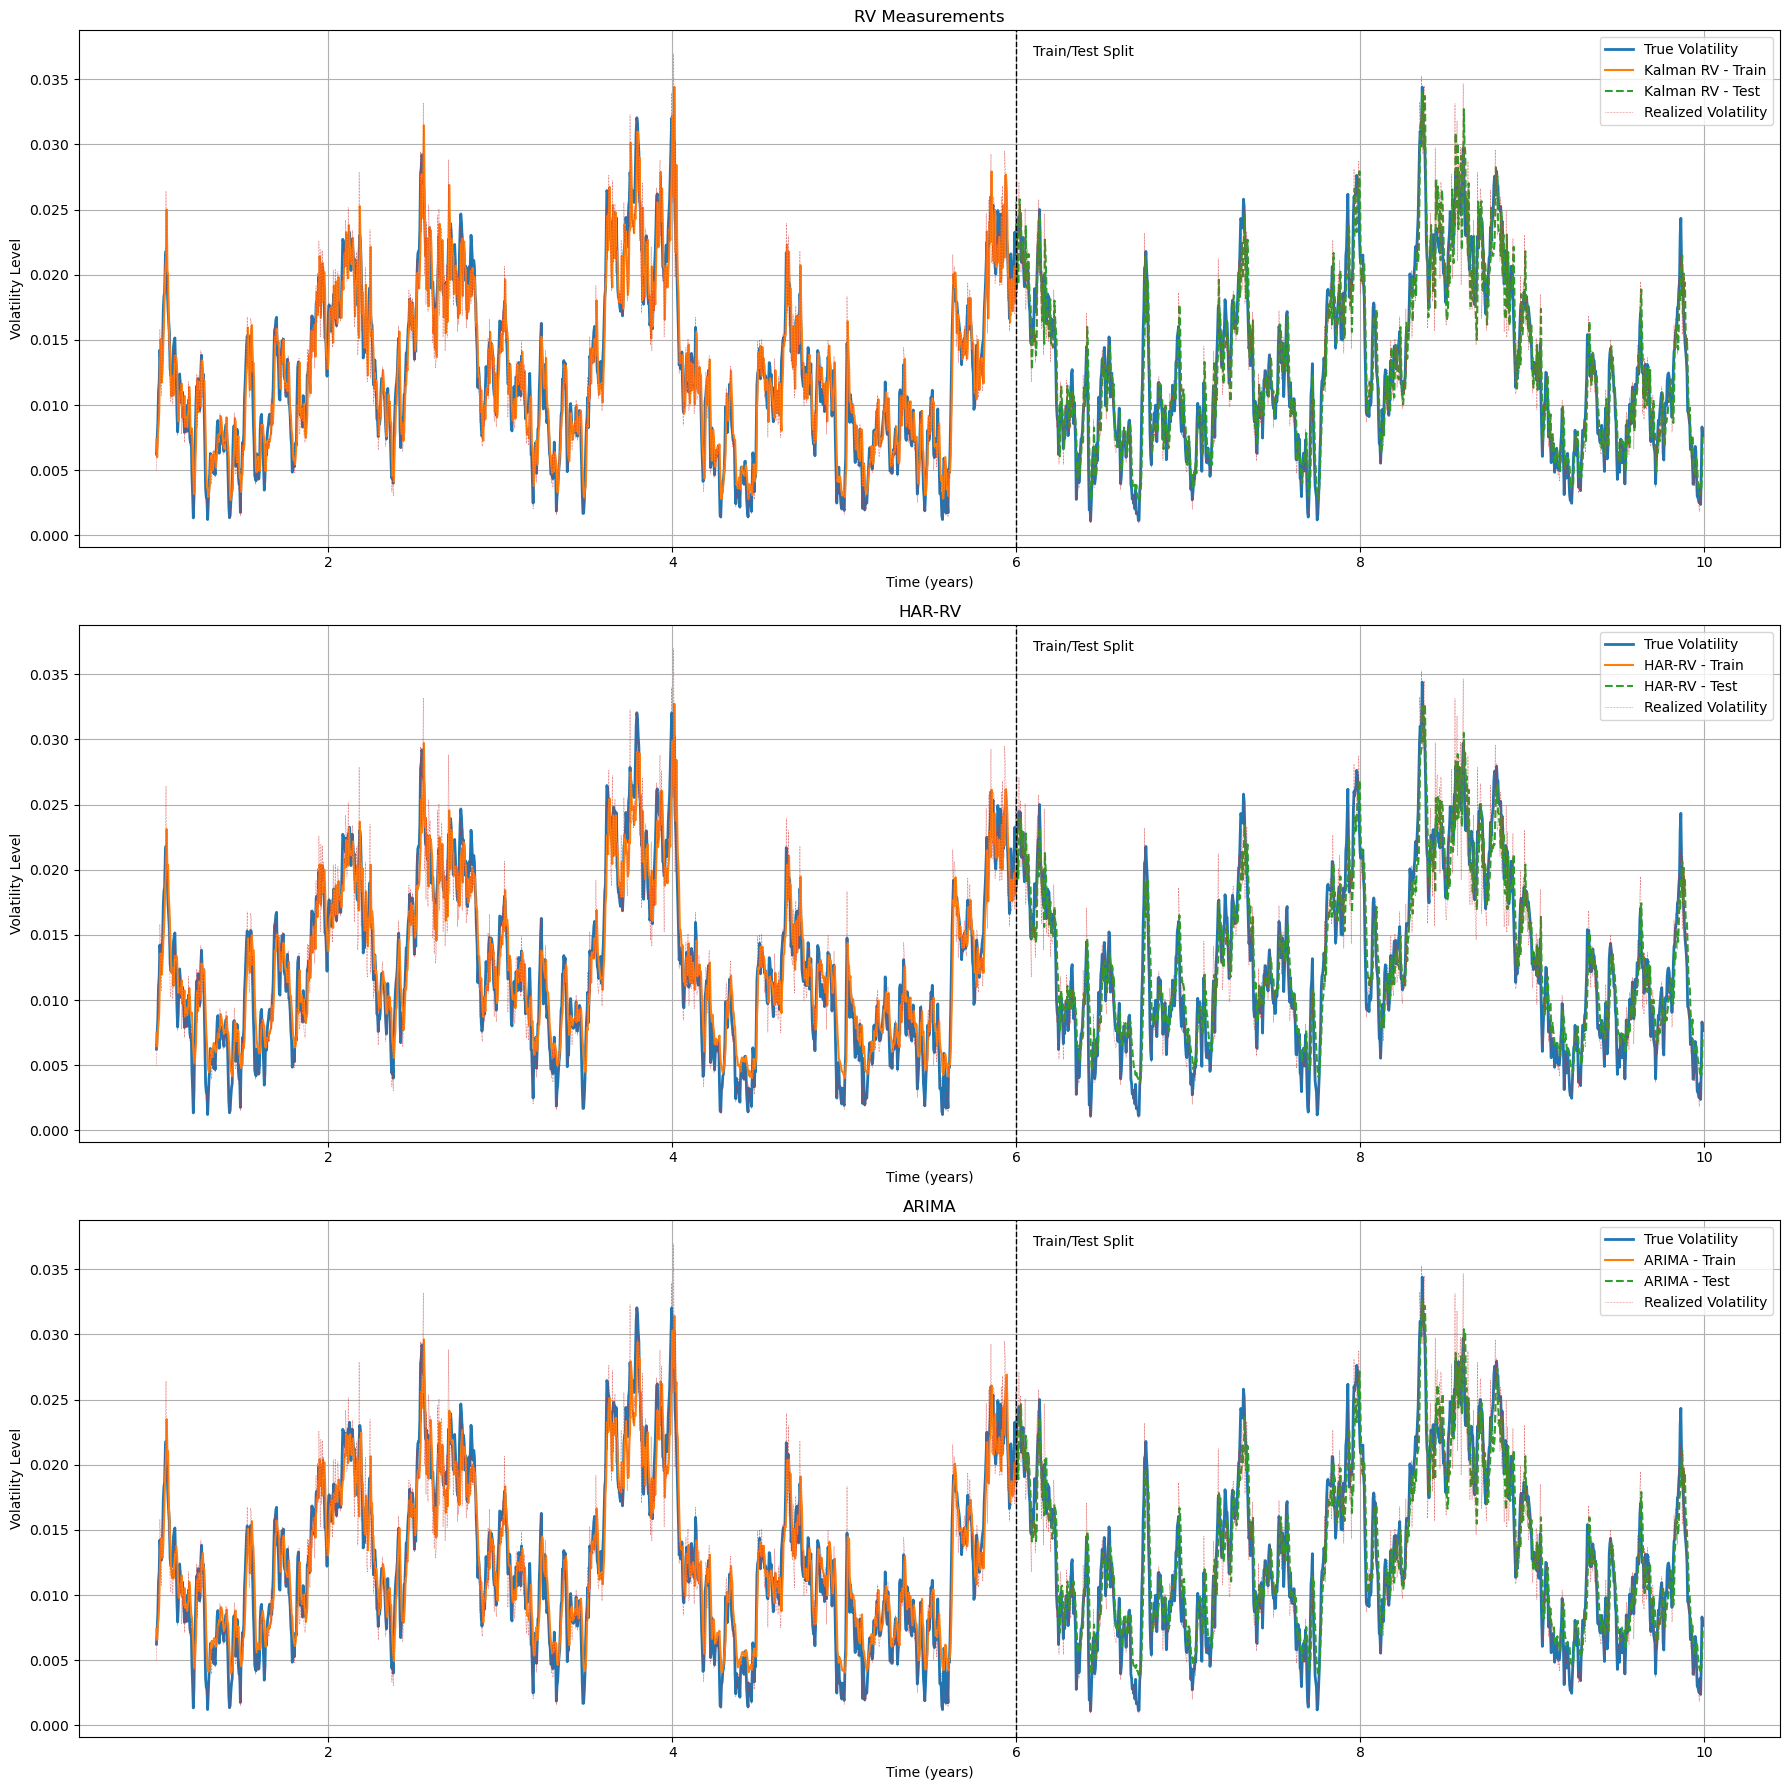

In [47]:
v_item = 'V_pred'

titles_all = ["RV Measurements", "HAR-RV", "ARIMA"]
labels_all = ["Kalman RV", "HAR-RV", "ARIMA"]
train_all = [train_result_rv[v_item], fit_HAR, fit_ARIMA]
test_all = [test_result_rv[v_item], pred_HAR, pred_ARIMA]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252
)

In [54]:
dict(zip(['kappa', 'theta', 'xi', 'varsigma'], params_opt_rv)), params_HAR, params_ARIMA

({'kappa': 0.02177686346447667,
  'theta': 0.00020100457978066135,
  'xi': 0.0042105083006638245,
  'varsigma': 0.002681503339243113},
 {'const': 1.1106880996747895e-05,
  'x1': 0.4334764827891181,
  'x5': 0.47471216597612864,
  'x21': 0.03663648182874809},
 {'order': (3, 0, 0),
  'aic': -39651.1023764543,
  'bic': -39621.94429007253,
  'llf': 19830.55118822715,
  'ar_L1': 0.48700456536245607,
  'ar_L2': 0.21928511443158674,
  'ar_L3': 0.22584773734444738,
  'const': 0.0001926551390806779})

In [48]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['RV-QLKF', 'HAR-RV', 'ARIMA']
true_variances   = daily_true_V[split_index:]
true_volatilities = np.sqrt(true_variances)

rmse_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, np.array(test_all).clip(1e-9, None)):
    pred_vol = np.sqrt(pred_var)
    
    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results:")
for name in model_names:
    print(f"{name:18s} RMSE: {rmse_scores[name]:.6f}, "
          f"QLIKE: {qlike_scores[name]:.6f}")

Results:
RV-QLKF            RMSE: 0.002165, QLIKE: 0.084165
HAR-RV             RMSE: 0.002285, QLIKE: 0.104162
ARIMA              RMSE: 0.002253, QLIKE: 0.099180


In [49]:
# Apply the same preprocessing: fix negatives and compute loss matrices
corrected_preds = []
mse_matrix = []
qlike_matrix = []

def qlike(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return ratio - np.log(ratio) - 1

for forecast in test_all:
    pred_var = np.array(forecast)

    # Fix negative variances
    neg_mask = pred_var < 0
    pred_var[neg_mask] = true_variances[neg_mask]

    # Compute predicted vol
    pred_vol = np.sqrt(pred_var)

    # Store for matrix stacking
    mse_matrix.append((true_volatilities - pred_vol)**2)
    qlike_matrix.append(qlike(true_variances, pred_var))

# Stack as columns: shape (T, num_models)
mse_matrix = np.column_stack(mse_matrix)
qlike_matrix = np.column_stack(qlike_matrix)

# Initialize and compute Model Confidence Set (MCS)
from model_confidence_set import ModelConfidenceSet

mcs_mse_90 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.10, show_progress=True)
mcs_qlike_90 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.10, show_progress=True)

mcs_mse_75 = ModelConfidenceSet(mse_matrix, n_boot=10000, alpha=0.25, show_progress=True)
mcs_qlike_75 = ModelConfidenceSet(qlike_matrix, n_boot=10000, alpha=0.25, show_progress=True)

mcs_mse_90.compute()
mcs_qlike_90.compute()

mcs_mse_75.compute()
mcs_qlike_75.compute()

mcs_mse_results_90 = mcs_mse_90.results()
mcs_qlike_results_90 = mcs_qlike_90.results()

mcs_mse_results_75 = mcs_mse_75.results()
mcs_qlike_results_75 = mcs_qlike_75.results()

Computing MCS: 100%|██████████| 2/2 [00:00<00:00, 933.31model/s]


In [50]:
mcs_mse_results_90

,pvalues,status
models,,
2,0.0555,excluded
3,0.0555,excluded
1,1.0000,included


In [51]:
mcs_qlike_results_90

,pvalues,status
models,,
2,0.0095,excluded
3,0.0095,excluded
1,1.0000,included


In [52]:
mcs_mse_results_75

,pvalues,status
models,,
2,0.0559,excluded
3,0.0559,excluded
1,1.0000,included


In [53]:
mcs_qlike_results_75

,pvalues,status
models,,
2,0.0105,excluded
3,0.0105,excluded
1,1.0000,included
